In [134]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns

In [133]:
#normalization step
def normalize(df):
  '''
  normalizes columns of dataframe in place
  '''
  for col in df:
    col_mean = np.mean(df[col])
    col_std = np.std(df[col])
    df[col] = (df[col]-col_mean)/col_std
  

In [137]:
def get_random(df,num_random):
  '''
  selects random indices for clustering if data set is too large to fully cluster
  returns dataset with num_random rows
  '''
  return df.iloc[[random.randint(0,df.shape[0]-1) for _ in range(num_random)]]

In [144]:
def k_means(df,k,stop_param, normal = False, rand = False, num_rand = 0):
  '''
  returns centroids and clustering assignments using k_means clustering
  '''
  if normal: normalize(df)
  if rand: random_df = get_random(df,num_rand)
  else: random_df = df

  #groups = {2: ['red','blue'],3:['red','blue','green'],4:['red','blue','green','yellow'],5:['red','blue','green','yellow','black']}
  coords = {n: np.array([random.uniform(min(df[col]), max(df[col])) for col in random_df.columns]) for n in range(k)}
  cluster = {n:[] for n in range(k)}

  while True:
    for index, row in random_df.iterrows():
      dic = {key : np.linalg.norm(row - val) for key,val in coords.items()}
      cluster[min(dic,key = dic.get)].append(index)
    
    max_dif = 0
    for color,val in coords.items():
      new_mean = df.iloc[cluster[color]].mean()
      new_dif = np.linalg.norm(new_mean-val)
      max_dif = new_dif if new_dif > max_dif else max_dif
      coords[color] = new_mean

    if max_dif < stop_param:
      break
    else:
      cluster = {n:[] for n in range(k)}
  
  def assign(x):
    dic = {key : np.linalg.norm(x - val) for key,val in coords.items()}
    return min(dic,key = dic.get)

  assignments = df.apply(assign, axis = 1)
  #this will return final centroids
  return assignments,coords

In [148]:
def PCA(df,num_axis):
  '''
  performs principal component analysis on dataframe
  returns np array of principal components
  '''
  new_df = df.copy()
  normalize(new_df)
  covar = np.cov(new_df, rowvar = False)
  evals,evecs = np.linalg.eig(covar)

  ind = np.argpartition(evals, -num_axis)[-num_axis:]
  pc = evecs[:,ind]
  return pc

In [149]:
def kmeans_pca_final(df,pca_num_axis,k_clusters,stop_param, normal = False, rand = False, num_rand = 0):
  '''
  combine k_means and PCA and return transformed dataframe
  '''
  assignments,centroids = k_means(df,k_clusters,stop_param,normal,rand,num_rand) 
  pc = PCA(df,pca_num_axis)
  pc_df= df@pc
  pc_df.columns = ['PCA_'+str(n) for n in range(pca_num_axis)]
  pc_df['clusters'] = assignments
  return pc_df


In [169]:
#upload desired data
file_name = 'wine-clustering.csv'
#file_name = 'credit_card_clustering.csv'
df = pd.read_csv(file_name)
#clean up data to only contain numerical values, haven't dealt with strings yet

In [172]:
pc_df = kmeans_pca_final(df = df,pca_num_axis = 2, k_clusters = 3, stop_param = 0.0001, normal = True)

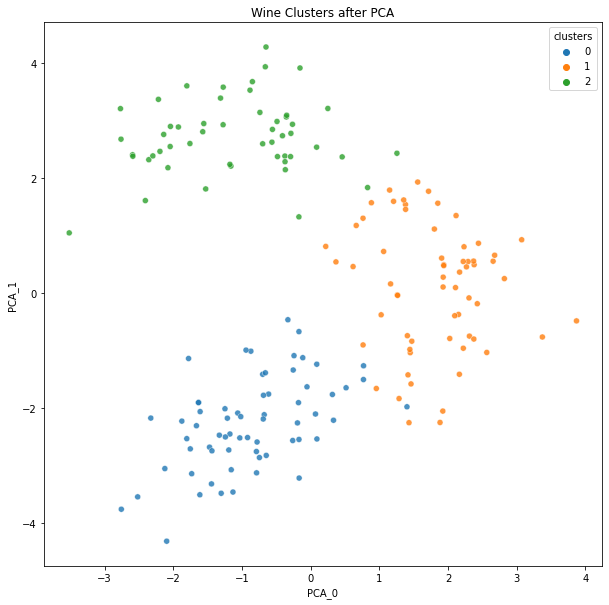

In [173]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=pc_df, x='PCA_0', y='PCA_1', hue='clusters', palette='tab10', alpha=0.8)
plt.title('Wine Clusters after PCA');